In [ ]:
# 벡터 데이터베이스(Vector Database, Vector DB)를 활용하여 이미지의 특징 벡터(Feature Vector)를 저장하고 유사한 이미지를 검색하는 과정
# Image Embedding을 활용한 유사 이미지 검색 시스템을 구축하는 과정
# 핵심은 이미지를 숫자로 이루어진 벡터(Embedding)로 변환하고, 이 벡터를 벡터 데이터베이스에 저장하여 빠르고 정확하게 유사도를 계산하는 것

!pip install koreanize_matplotlib   # 데이터 시각화 시 한글 폰트 문제를 해결

In [ ]:
# kaggle dataset 이미지 관련 자료 읽기
!wget -q https://github.com/kairess/toy-datasets/raw/master/Food-11.zip
!unzip -oq Food-11.zip      # 다운로드한 zip 파일의 압축을 해제합니다. (-q는 조용히, -o는 덮어쓰기, -k는 건너뛰기)

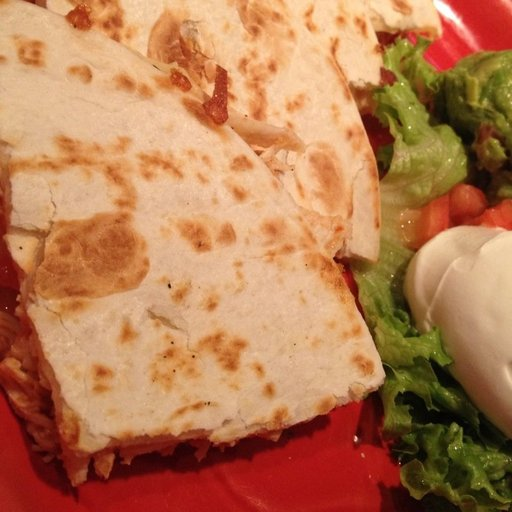

In [3]:
from PIL import Image
img = Image.open("test/Bread/0.jpg")
img

In [ ]:
from transformers import ViTFeatureExtractor, ViTModel

feature_extractor = ViTFeatureExtractor.from_pretrained('facebook/dino-vits16') # 모델에 입력되기 전에 이미지 데이터를 전처리(Pre-process)하는 역할
model = ViTModel.from_pretrained('facebook/dino-vits16')


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/transformers/models/vit/feature_extraction_vit.py:30: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
Some weights of ViTModel were not initialized from the model checkpoint at facebook/dino-vits16 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream ta

ViT는 Transformer 구조를 이미지 처리에 적용한 혁신적인 모델
S16은 모델의 크기(Small)와 이미지 패치(Patch) 크기(16x16)를 나타내며, 이미지 특징을 추출하는 기초적인 백본(Backbone) 역할

NLP (자연어 처리): 문장 → 단어(Token)로 분리
ViT (이미지 처리): 이미지 → 패치(Patch)로 분리
ViT는 이미지를 한 번에 통째로 보는 대신, 가로/세로가 일정한 크기(예: 16 x 16 픽셀)의 겹치지 않는 작은 조각(패치)들로 나눕

DINO (Self-DIstillation with NO labels)
DINO는 Meta AI (구 Facebook AI)에서 제안한 자기 지도 학습(Self-Supervised Learning) 방법.
이 방법의 특징은 레이블(정답)이 없는 대량의 이미지 데이터만으로도 매우 강력한 시각적 특징 추출 능력을 학습할 수 있다는 것.
DINO로 학습된 ViT 모델은 이미지 분류뿐만 아니라, 객체 분할(Segmentation)이나 특징 시각화 등 다양한 컴퓨터 비전 작업에서 뛰어난 성능을 보임.

* 사용 목적 
특징 추출 (Feature Extraction): 이미지에서 고차원적인 정보를 담고 있는 벡터(임베딩)를 추출. 이는 이미지 검색, 유사도 비교, 군집화(Clustering) 등 데이터 분석 작업의 입력으로 활용.
전이 학습 (Transfer Learning): 이 모델의 학습된 가중치(Weights)를 가져와, 사용자가 가진 특정 이미지 데이터셋에 맞게 모델의 마지막 층만 재학습(Fine-tuning)하여 성능을 높이는 데 사용.

In [ ]:
# 이미지 전처리

# 1. PIL Image 객체 (img)를 모델 입력에 적합한 형태로 변환
# ViT 모델은 특정 크기와 정규화된 형태의 텐서를 입력으로 요구
img_tensor = feature_extractor(images=img, return_tensors='pt')
# 원본 PIL Image 객체를 입력합니다. (이미지 데이터)
# # 출력 형태를 PyTorch(pt) 텐서로 지정


outputs = model(**img_tensor)   
embedding = outputs.pooler_output.detach().numpy().squeeze()      
# 모델이 출력한 결과(outputs)에서 이미지 전체를 요약하는 임베딩 벡터(pooler_output)를 추출 = PyTorch 텐서를 NumPy 배열로 변환하고(numpy()), 계산 그래프에서 분리(detach())하며, 불필요한 차원(크기 1인 차원)을 제거(squeeze())하여 순수한 1차원 벡터
# outputs.pooler_output : 이미지 전체에 대한 요약 임베딩
# detach() :역전파 끊기 (학습x)
print(embedding.shape)
print(embedding[:5])

(384,)
[ 0.36559185  0.930152    0.9614324   0.9988962  -0.66185355]


In [6]:
!pip install chromadb

In [ ]:
import chromadb
client = chromadb.Client()
collection = client.get_or_create_collection('foods')
# foods라는 이름의 컬렉션 (데이터가 저장될 저장소)을 생성하거나 이미 존재하면 가져옵니다.


from glob import glob # 파일 경로에 wildcard 문자 (?,*) 사용
img_list = sorted(glob('test/*/*.jpg')) # test 폴더 아래의 모든 하위 폴더에서 .jpg 파일을 찾아서 이미지 경로 목록을 생성
print(len(img_list))    # 찾은 이미지 파일의 총 개수를 출력

110


In [ ]:
from tqdm import tqdm

# 각 이미지에 대한 embedding, metadata, id  생성
# Vector DB에 저장할 3가지 필수 구성 요소를 담기 위해 빈 리스트를 준비
embeddings = []
metadatas = []
ids = []

# img_list에 있는 이미지 경로를 하나씩 처리
for i, img_path in enumerate(tqdm(img_list)):
  img = Image.open(img_path)
  # 'test/Bread/0.jpg.... 에서 bread를 추출해 클래스명으로 사용 예정
  cls = img_path.split('/')[1]
  # print(cls)
  # 특징 추출 (Feature Extraction) 과정
  img_tensor = feature_extractor(images=img, return_tensors='pt')   # 전처리 및 PyTorch 텐서 변환
  outputs = model(**img_tensor) # ViT 모델에 텐서 입력
  embedding = outputs.pooler_output.detach().numpy().squeeze().tolist() # 임베딩 추출 후 NumPy -> 파이썬 리스트(tolist())로 변환 (ChromaDB 입력 형식)
  
  # 준비된 리스트에 결과 추가
  embeddings.append(embedding)
  metadatas.append(
      {
          'uri':img_path,
          'name':cls
      }
  )
  ids.append(str(i))    # 반복 순서(i)를 문자열 ID로 변환하여 추가
  print('각 이미지 벡터에 저장 준비 작업 종료') # 모든 작업이 완료되었음을 알림


print(embeddings) # 생성된 임베딩 리스트 확인
print(metadatas)  # 생성된 메타데이터 리스트 확인
print(ids)        # 생성된 ID 리스트 확인

# VetorDB에 저장
collection.add(
    embeddings=embeddings, # 임베딩 벡터 목록
    metadatas=metadatas,   # 메타데이터 딕셔너리 목록
    ids=ids                # 고유 ID 목록
)

  1%|          | 1/110 [00:00<01:24,  1.28it/s]

각 이미지 벡터에 저장 준비 작업 종료


  2%|▏         | 2/110 [00:01<01:20,  1.35it/s]

각 이미지 벡터에 저장 준비 작업 종료


  3%|▎         | 3/110 [00:01<01:03,  1.69it/s]

각 이미지 벡터에 저장 준비 작업 종료


  4%|▎         | 4/110 [00:02<00:47,  2.21it/s]

각 이미지 벡터에 저장 준비 작업 종료


  5%|▍         | 5/110 [00:02<00:46,  2.23it/s]

각 이미지 벡터에 저장 준비 작업 종료


  5%|▌         | 6/110 [00:03<00:58,  1.77it/s]

각 이미지 벡터에 저장 준비 작업 종료


  6%|▋         | 7/110 [00:04<01:04,  1.61it/s]

각 이미지 벡터에 저장 준비 작업 종료


  8%|▊         | 9/110 [00:04<00:45,  2.20it/s]

각 이미지 벡터에 저장 준비 작업 종료
각 이미지 벡터에 저장 준비 작업 종료


  9%|▉         | 10/110 [00:05<00:45,  2.19it/s]

각 이미지 벡터에 저장 준비 작업 종료


 10%|█         | 11/110 [00:05<00:52,  1.89it/s]

각 이미지 벡터에 저장 준비 작업 종료


 11%|█         | 12/110 [00:06<00:56,  1.73it/s]

각 이미지 벡터에 저장 준비 작업 종료


 12%|█▏        | 13/110 [00:07<00:56,  1.71it/s]

각 이미지 벡터에 저장 준비 작업 종료


 14%|█▎        | 15/110 [00:07<00:35,  2.66it/s]

각 이미지 벡터에 저장 준비 작업 종료
각 이미지 벡터에 저장 준비 작업 종료


 15%|█▍        | 16/110 [00:07<00:30,  3.09it/s]

각 이미지 벡터에 저장 준비 작업 종료


 15%|█▌        | 17/110 [00:08<00:26,  3.47it/s]

각 이미지 벡터에 저장 준비 작업 종료


 17%|█▋        | 19/110 [00:08<00:22,  4.10it/s]

각 이미지 벡터에 저장 준비 작업 종료
각 이미지 벡터에 저장 준비 작업 종료


 19%|█▉        | 21/110 [00:08<00:19,  4.60it/s]

각 이미지 벡터에 저장 준비 작업 종료
각 이미지 벡터에 저장 준비 작업 종료


 21%|██        | 23/110 [00:09<00:17,  5.10it/s]

각 이미지 벡터에 저장 준비 작업 종료
각 이미지 벡터에 저장 준비 작업 종료


 23%|██▎       | 25/110 [00:09<00:14,  5.86it/s]

각 이미지 벡터에 저장 준비 작업 종료
각 이미지 벡터에 저장 준비 작업 종료


 25%|██▍       | 27/110 [00:09<00:13,  6.13it/s]

각 이미지 벡터에 저장 준비 작업 종료
각 이미지 벡터에 저장 준비 작업 종료


 26%|██▋       | 29/110 [00:10<00:12,  6.28it/s]

각 이미지 벡터에 저장 준비 작업 종료
각 이미지 벡터에 저장 준비 작업 종료


 28%|██▊       | 31/110 [00:10<00:12,  6.36it/s]

각 이미지 벡터에 저장 준비 작업 종료
각 이미지 벡터에 저장 준비 작업 종료


 30%|███       | 33/110 [00:10<00:11,  6.54it/s]

각 이미지 벡터에 저장 준비 작업 종료
각 이미지 벡터에 저장 준비 작업 종료


 32%|███▏      | 35/110 [00:10<00:11,  6.53it/s]

각 이미지 벡터에 저장 준비 작업 종료
각 이미지 벡터에 저장 준비 작업 종료


 34%|███▎      | 37/110 [00:11<00:10,  6.69it/s]

각 이미지 벡터에 저장 준비 작업 종료
각 이미지 벡터에 저장 준비 작업 종료


 35%|███▌      | 39/110 [00:11<00:10,  6.63it/s]

각 이미지 벡터에 저장 준비 작업 종료
각 이미지 벡터에 저장 준비 작업 종료


 37%|███▋      | 41/110 [00:11<00:10,  6.69it/s]

각 이미지 벡터에 저장 준비 작업 종료
각 이미지 벡터에 저장 준비 작업 종료


 39%|███▉      | 43/110 [00:12<00:10,  6.70it/s]

각 이미지 벡터에 저장 준비 작업 종료
각 이미지 벡터에 저장 준비 작업 종료


 41%|████      | 45/110 [00:12<00:09,  6.67it/s]

각 이미지 벡터에 저장 준비 작업 종료
각 이미지 벡터에 저장 준비 작업 종료


 43%|████▎     | 47/110 [00:12<00:09,  6.59it/s]

각 이미지 벡터에 저장 준비 작업 종료
각 이미지 벡터에 저장 준비 작업 종료


 45%|████▍     | 49/110 [00:13<00:09,  6.56it/s]

각 이미지 벡터에 저장 준비 작업 종료
각 이미지 벡터에 저장 준비 작업 종료


 46%|████▋     | 51/110 [00:13<00:09,  6.42it/s]

각 이미지 벡터에 저장 준비 작업 종료
각 이미지 벡터에 저장 준비 작업 종료


 48%|████▊     | 53/110 [00:13<00:08,  6.36it/s]

각 이미지 벡터에 저장 준비 작업 종료
각 이미지 벡터에 저장 준비 작업 종료


 50%|█████     | 55/110 [00:14<00:08,  6.50it/s]

각 이미지 벡터에 저장 준비 작업 종료
각 이미지 벡터에 저장 준비 작업 종료


 52%|█████▏    | 57/110 [00:14<00:08,  6.60it/s]

각 이미지 벡터에 저장 준비 작업 종료
각 이미지 벡터에 저장 준비 작업 종료


 53%|█████▎    | 58/110 [00:14<00:08,  6.26it/s]

각 이미지 벡터에 저장 준비 작업 종료


 55%|█████▍    | 60/110 [00:14<00:08,  5.86it/s]

각 이미지 벡터에 저장 준비 작업 종료
각 이미지 벡터에 저장 준비 작업 종료


 56%|█████▋    | 62/110 [00:15<00:07,  6.09it/s]

각 이미지 벡터에 저장 준비 작업 종료
각 이미지 벡터에 저장 준비 작업 종료


 58%|█████▊    | 64/110 [00:15<00:07,  5.99it/s]

각 이미지 벡터에 저장 준비 작업 종료
각 이미지 벡터에 저장 준비 작업 종료


 59%|█████▉    | 65/110 [00:15<00:07,  6.09it/s]

각 이미지 벡터에 저장 준비 작업 종료


 61%|██████    | 67/110 [00:16<00:07,  5.45it/s]

각 이미지 벡터에 저장 준비 작업 종료
각 이미지 벡터에 저장 준비 작업 종료


 62%|██████▏   | 68/110 [00:16<00:07,  5.79it/s]

각 이미지 벡터에 저장 준비 작업 종료


 63%|██████▎   | 69/110 [00:16<00:08,  4.78it/s]

각 이미지 벡터에 저장 준비 작업 종료


 65%|██████▍   | 71/110 [00:16<00:07,  4.90it/s]

각 이미지 벡터에 저장 준비 작업 종료
각 이미지 벡터에 저장 준비 작업 종료


 66%|██████▋   | 73/110 [00:17<00:06,  5.64it/s]

각 이미지 벡터에 저장 준비 작업 종료
각 이미지 벡터에 저장 준비 작업 종료


 68%|██████▊   | 75/110 [00:17<00:05,  6.01it/s]

각 이미지 벡터에 저장 준비 작업 종료
각 이미지 벡터에 저장 준비 작업 종료


 70%|███████   | 77/110 [00:17<00:05,  6.16it/s]

각 이미지 벡터에 저장 준비 작업 종료
각 이미지 벡터에 저장 준비 작업 종료


 72%|███████▏  | 79/110 [00:18<00:04,  6.20it/s]

각 이미지 벡터에 저장 준비 작업 종료
각 이미지 벡터에 저장 준비 작업 종료


 74%|███████▎  | 81/110 [00:18<00:04,  6.32it/s]

각 이미지 벡터에 저장 준비 작업 종료
각 이미지 벡터에 저장 준비 작업 종료


 75%|███████▌  | 83/110 [00:18<00:04,  6.28it/s]

각 이미지 벡터에 저장 준비 작업 종료
각 이미지 벡터에 저장 준비 작업 종료


 77%|███████▋  | 85/110 [00:19<00:04,  5.86it/s]

각 이미지 벡터에 저장 준비 작업 종료
각 이미지 벡터에 저장 준비 작업 종료


 78%|███████▊  | 86/110 [00:19<00:04,  5.37it/s]

각 이미지 벡터에 저장 준비 작업 종료
각 이미지 벡터에 저장 준비 작업 종료


 80%|████████  | 88/110 [00:19<00:04,  5.11it/s]

각 이미지 벡터에 저장 준비 작업 종료


 81%|████████  | 89/110 [00:20<00:04,  4.99it/s]

각 이미지 벡터에 저장 준비 작업 종료


 83%|████████▎ | 91/110 [00:20<00:03,  5.00it/s]

각 이미지 벡터에 저장 준비 작업 종료
각 이미지 벡터에 저장 준비 작업 종료


 85%|████████▍ | 93/110 [00:20<00:03,  5.57it/s]

각 이미지 벡터에 저장 준비 작업 종료
각 이미지 벡터에 저장 준비 작업 종료


 86%|████████▋ | 95/110 [00:21<00:02,  6.19it/s]

각 이미지 벡터에 저장 준비 작업 종료
각 이미지 벡터에 저장 준비 작업 종료


 88%|████████▊ | 97/110 [00:21<00:02,  6.43it/s]

각 이미지 벡터에 저장 준비 작업 종료
각 이미지 벡터에 저장 준비 작업 종료


 90%|█████████ | 99/110 [00:21<00:01,  6.52it/s]

각 이미지 벡터에 저장 준비 작업 종료
각 이미지 벡터에 저장 준비 작업 종료


 92%|█████████▏| 101/110 [00:21<00:01,  6.38it/s]

각 이미지 벡터에 저장 준비 작업 종료
각 이미지 벡터에 저장 준비 작업 종료


 94%|█████████▎| 103/110 [00:22<00:01,  6.27it/s]

각 이미지 벡터에 저장 준비 작업 종료
각 이미지 벡터에 저장 준비 작업 종료


 95%|█████████▌| 105/110 [00:22<00:00,  6.56it/s]

각 이미지 벡터에 저장 준비 작업 종료
각 이미지 벡터에 저장 준비 작업 종료


 97%|█████████▋| 107/110 [00:22<00:00,  6.29it/s]

각 이미지 벡터에 저장 준비 작업 종료
각 이미지 벡터에 저장 준비 작업 종료


 99%|█████████▉| 109/110 [00:23<00:00,  6.52it/s]

각 이미지 벡터에 저장 준비 작업 종료
각 이미지 벡터에 저장 준비 작업 종료


100%|██████████| 110/110 [00:23<00:00,  4.70it/s]


각 이미지 벡터에 저장 준비 작업 종료
[[0.3655918538570404, 0.9301519989967346, 0.9614323973655701, 0.9988961815834045, -0.661853551864624, -0.06070365011692047, 0.8340927362442017, -0.8672141432762146, -0.9510550498962402, 0.6652395725250244, -0.3904706835746765, -0.2855125069618225, -0.9577053189277649, 0.933222234249115, -0.011664606630802155, -0.6733041405677795, -0.9444539546966553, 0.9914169311523438, 0.5001617074012756, 0.982815146446228, -0.8454383015632629, -0.9016026258468628, 0.11615297943353653, -0.7808095812797546, -0.8025522828102112, 0.9981808662414551, -0.9881332516670227, -0.5685332417488098, 0.9361540079116821, 0.9976786971092224, -0.11665087193250656, -0.7055411338806152, -0.9996531009674072, -0.960914134979248, 0.9747207164764404, 0.9187091588973999, 0.967056393623352, -0.9665086269378662, 0.8728892207145691, 0.8743942379951477, 0.97244793176651, 0.9984654784202576, 0.6104276180267334, 0.9763599634170532, -0.03957653045654297, -0.1329873502254486, -0.9985227584838867, -0.9951809644

1. 모델의 출력 (pooler_output)
* 기능: 이미지를 숫자 벡터(임베딩)로 압축하여 이미지의 의미적 정보를 담음.
* 활용: 이 벡터를 사용하여 다른 이미지와의 유사도를 계산하거나 클러스터링을 할 수 있음.

2. ChromaDB (Vector Database)
* 기능: 추출된 고차원 벡터(embeddings)와 그 벡터에 대한 부가 정보(metadatas)를 효율적으로 저장하고, 벡터 기반으로 빠르게 검색할 수 있게 해주는 데이터베이스.
* 필요성: 단순히 파일로 저장하는 것보다 벡터 검색에 최적화되어 있어, 대규모 이미지 검색 시스템을 구축하는 데 필수적.

3. 데이터 구조화
Vector DB에 저장하기 위해서는 다음 세 가지 데이터가 리스트 형태로 준비.

데이터 이름     코드 변수           데이터 형태              역할
임베딩        embeddings        리스트 (float)      이미지의 특징(실제 벡터)
메타데이터     metadatas        딕셔너리 (Dict)      벡터에 대한 설명 (경로, 클래스 이름 등)
ID              ids             문자열 (String)     각 벡터를 식별하는 고유 번호

4. 클래스명 추출 (cls = img_path.split('/')[1])
* 목적: 이미지 파일 경로가 보통 폴더명/파일명 구조로 되어 있을 때, 폴더명을 이미지의 카테고리(클래스)로 활용하기 위해 추출하는 데이터 처리 기법. 
* 추출된 cls는 Vector DB의 metadatas에 저장되어 나중에 특정 카테고리별로 검색하거나 필터링할 때 사용.

384
{'ids': [['8', '2', '6']], 'embeddings': None, 'documents': [[None, None, None]], 'uris': None, 'included': ['metadatas', 'documents', 'distances'], 'data': None, 'metadatas': [[{'name': 'Bread', 'uri': 'test/Bread/8.jpg'}, {'uri': 'test/Bread/2.jpg', 'name': 'Bread'}, {'name': 'Bread', 'uri': 'test/Bread/6.jpg'}]], 'distances': [[160.9469451904297, 232.75347900390625, 265.9613342285156]]}


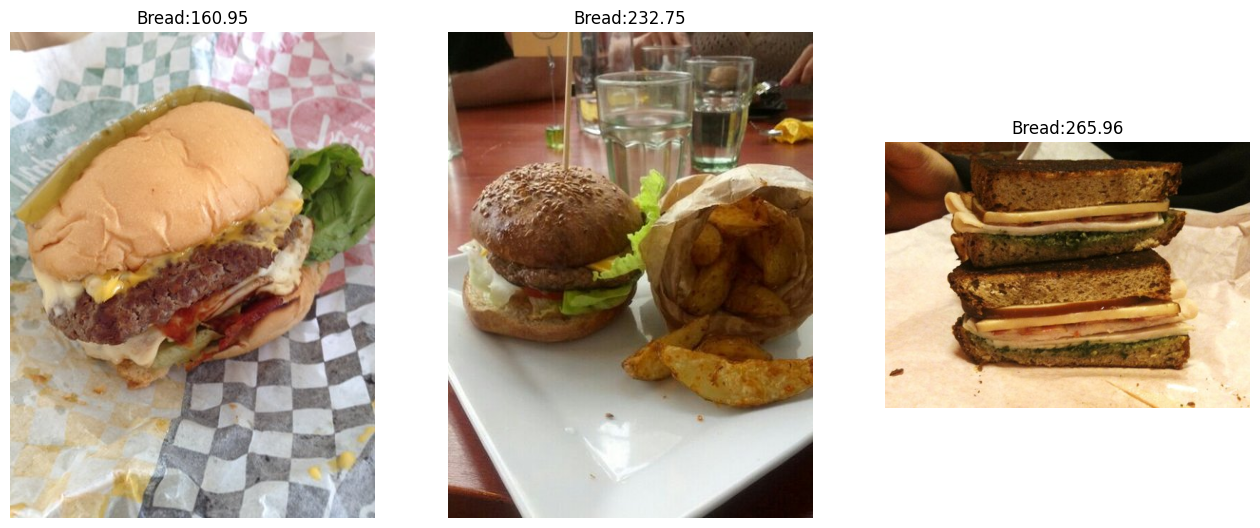

In [ ]:
# 이미지 검색 
import requests
# requests를 사용하여 웹상의 이미지 URL에서 이미지를 다운로드하고 PIL Image 객체로 OPEN.
test_img = Image.open(requests.get("https://i.ibb.co/7Ksr5mw/yNp6qTS.png",stream=True).raw)
test_img

# 검색 이미지 전처리
test_img_tensor = feature_extractor(images=test_img, return_tensors='pt') # feature_extractor를 사용하여 이미지를 모델 입력에 맞게 전처리하고 PyTorch 텐서로 변환합니다.
test_outputs = model(**test_img_tensor)
test_embedding = test_outputs.pooler_output.detach().numpy().squeeze().tolist() # 모델 출력에서 임베딩 벡터를 추출하고 NumPy 배열을 거쳐 리스트(tolist) 형태로 변환
print(len(test_embedding))

# 검색 대상 이미지와 유사한 이미지들을 벡터DB에서 읽기
query_result = collection.query(
    query_embeddings=[test_embedding], # 검색을 위한 쿼리 임베딩 (방금 추출한 벡터)
    n_results = 3,                     # 가장 유사한 상위 3개의 결과를 요청.
)
print(query_result) # {'ids': [['8', '2', '6']], '...

# 이미지 시각화
import matplotlib.pyplot as plt
# Matplotlib을 사용하여 1행 3열의 서브플롯(Subplot)을 생성합니다. (결과 3개를 표시하기 위함)
fig, axes = plt.subplots(1,3,figsize=(16,10))

# 검색 결과에서 메타데이터(파일명, 클래스명)를 순회하며 시각화
for i, metadata in enumerate(query_result['metadatas'][0]):
  # 검색 결과에 포함된 거리(Distance) 정보를 가져옴. (유사할수록 거리가 작음)
  distance = query_result['distances'][0][i]
  # 메타데이터에 저장된 URI(파일 경로)를 이용해 이미지를 다시 로드하여 출력
  axes[i].imshow(Image.open(metadata['uri']))
  # 각 서브플롯의 제목을 '클래스명:거리' 형태로 설정
  axes[i].set_title(f'{metadata["name"]}:{distance:.2f}')
  axes[i].axis('off')


1. 검색 이미지 임베딩 추출
* 목표: Vector DB에 저장된 이미지 임베딩들과 비교하기 위해, 검색 대상 이미지를 동일한 ViT 모델을 사용하여 768차원 벡터(test_embedding)로 변환.
* 원칙: 검색할 때 사용하는 임베딩 모델은 DB 구축 시 사용한 모델과 반드시 동일
* 
2. 유사도 검색 (collection.query)
* 기능: ChromaDB의 핵심 기능. 입력된 query_embeddings와 DB 내에 저장된 모든 벡터 사이의 거리(Distance)를 계산하고, 거리가 가장 가까운 순서대로 결과를 반환.
* query_embeddings: 검색 대상 이미지의 임베딩 벡터.
* n_results: 찾고자 하는 유사 이미지의 개수 (여기서는 상위 3개)

3. 검색 결과(query_result) 구조
query_result는 딕셔너리 형태로 반환.

키 (Key)        담고 있는 내용                                                          역할
ids             DB에 저장된 이미지들의 고유 ID 목록                            어떤 이미지가 검색되었는지 식별
metadatas       DB에 저장된 이미지들의 부가 정보 (URI, name 등) 목록            이미지 파일 경로를 얻어 시각화에 사용
distances       검색 쿼리와 찾은 이미지 사이의 거리 값 목록                      이 값이 작을수록 검색 이미지와 더 유사하다는 의미입니다.


4. 결과 시각화
matplotlib: 데이터 분석 결과를 그래프나 이미지로 출력하는 표준 파이썬 라이브러리
distance 표시의 의미: 이미지 위에 거리 값을 표시함으로써, ViT 임베딩 공간에서 검색 쿼리와 해당 이미지가 얼마나 가까운 위치에 있는지(즉, 얼마나 유사한지)를 직관적으로 확인할 수 있음.
distance를 확인하여 유사도 검색이 성공적으로 이루어졌는지 검증할 수 있음